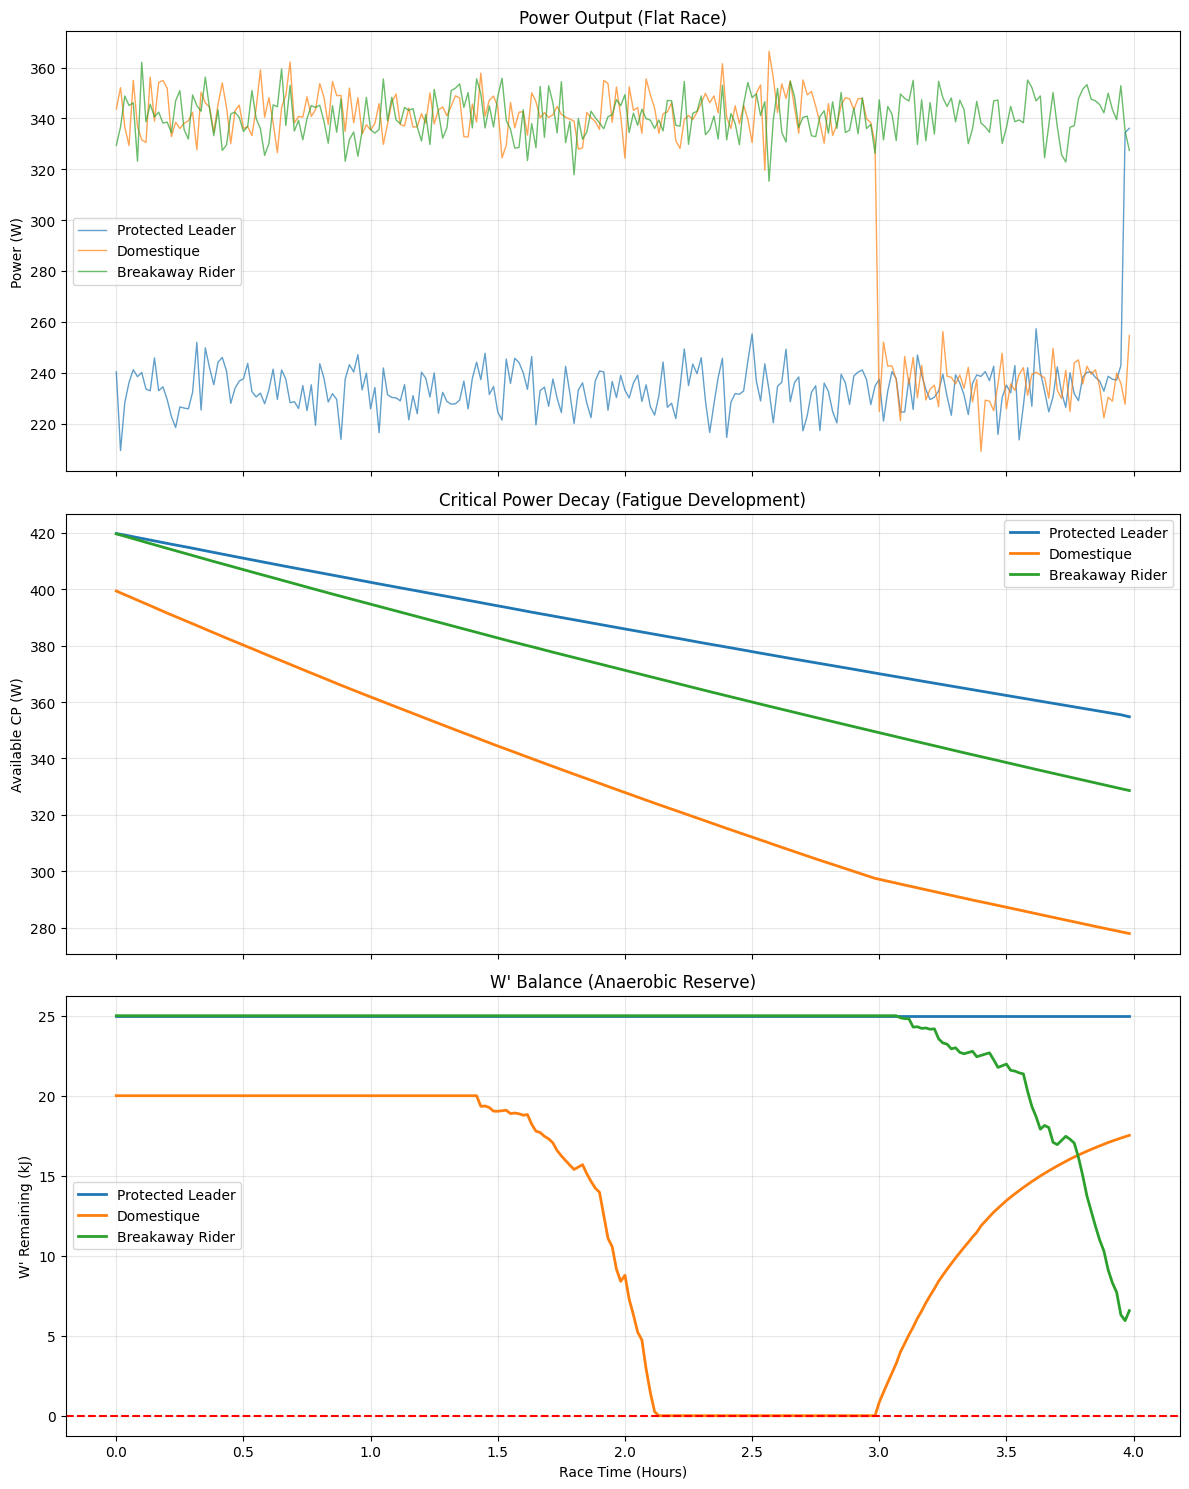

In [ ]:

# --- Simulation Setup (FLAT RACE) ---

import numpy as np
import matplotlib.pyplot as plt


class Rider:
    def __init__(
        self,
        name,
        cp_fresh,
        w_prime,
        fatigue_resistance_lambda,
        recovery_tau0=300.0,      # base recovery timescale (s)
        tau_min=30.0,             # fastest possible recovery (s)
        tau_max=1800.0,           # slowest possible recovery (s)
        role="Leader"
    ):
        self.name = name
        self.cp_fresh = cp_fresh               # Critical Power (W)
        self.w_prime_cap = w_prime             # W' capacity (J)
        self.w_prime_bal = w_prime             # current W' (J)

        self.lambda_factor = fatigue_resistance_lambda  # sensitivity to accumulated work (per kJ)
        self.recovery_tau0 = recovery_tau0
        self.tau_min = tau_min
        self.tau_max = tau_max

        self.role = role

        self.cp_current = cp_fresh
        self.total_work_kj = 0.0

        # History
        self.history = {
            'time': [],
            'cp': [],
            'w_prime': [],
            'power': []
        }

    def update_fatigue(self, power_output, dt, rain_factor=1.0):
        """
        Updates:
        1) accumulated work
        2) CP decay (exponential with accumulated work)
        3) W' dynamics:
           - depletion above CP
           - exponential reconstitution below CP with tau depending on how easy it is
        """

        # --- Accumulate work (kJ) ---
        step_work_kj = (power_output * dt) / 1000.0
        self.total_work_kj += step_work_kj

        # --- 1) Exponential CP decay (durability) ---
        decay_exponent = -self.lambda_factor * self.total_work_kj * rain_factor
        cp_unfloored = self.cp_fresh * np.exp(decay_exponent)
        self.cp_current = max(0.5 * self.cp_fresh, cp_unfloored)

        # --- 2) W' dynamics ---
        if power_output > self.cp_current:

            drain = (power_output - self.cp_current) * dt
            self.w_prime_bal -= drain

        else:
            # Exponential reconstitution toward W'_max:
            dcp = self.cp_current - power_output  # how "easy" it is
            eps = 1e-6

            # tau scales like CP/dcp (large deficit => small tau => fast recovery)
            tau = self.recovery_tau0 * (self.cp_current / max(dcp, eps))
            tau = float(np.clip(tau, self.tau_min, self.tau_max))

            self.w_prime_bal = self.w_prime_cap - (self.w_prime_cap - self.w_prime_bal) * np.exp(-dt / tau)

        # Clamp W'
        self.w_prime_bal = max(0.0, min(self.w_prime_bal, self.w_prime_cap))

        # Store history
        self.history['cp'].append(self.cp_current)
        self.history['w_prime'].append(self.w_prime_bal)
        self.history['power'].append(power_output)


def calculate_power_required(speed_mps, slope_pct, is_drafting, wind_mps, rider_mass=70, bike_mass=7):
    # Constants
    g = 9.81
    rho = 1.225 # Air density
    crr = 0.004 # Rolling resistance
    
    # Drag Area (CdA)
    cda = 0.32 # Average rider on hoods/drops
    if is_drafting:
        cda = 0.32 * 0.65 # 35% savings in the draft
        
    total_mass = rider_mass + bike_mass
    
    # Forces
    # 1. Gravity: F_g = m * g * sin(arctan(slope)) ~ m * g * slope
    f_gravity = total_mass * g * (slope_pct / 100.0)
    
    # 2. Rolling Resistance: F_r = m * g * Crr
    f_rolling = total_mass * g * crr
    
    # 3. Aerodynamic Drag: F_a = 0.5 * rho * CdA * v^3
    v_air = speed_mps + wind_mps
    f_air = 0.5 * rho * cda * (v_air**2) * np.sign(v_air)
    
    total_force = f_gravity + f_rolling + f_air
    power = total_force * speed_mps
    
    return max(0, power) # No negative power (coasting = 0)


# Time settings
duration_hours = 4
dt = 60 # 1 minute steps (resolution)
time_steps = int(duration_hours * 3600 / dt)
time_axis = np.arange(0, duration_hours * 3600, dt) / 3600 # in Hours

# Race Profile (FLAT & STEADY)
# Constant speed, flat terrain, negligible wind
speed_profile = np.ones(time_steps) * 11.6 # ~42 km/h (Fast flat race)
slope_profile = np.zeros(time_steps)       # 0% gradient
wind_profile = np.zeros(time_steps)        # 0 wind (still air)
rain_profile = np.ones(time_steps)         # 1.0 (No rain stress)

# Create Riders
# Rider 1: Team Leader (Protected, high CP, high fatigue resistance)
leader = Rider(
    "Protected Leader",
    cp_fresh=420,
    w_prime=25000,
    fatigue_resistance_lambda=0.00005,
    recovery_tau0=280,   # faster recovery
    role="Leader"
)

domestique = Rider(
    "Domestique",
    cp_fresh=400,
    w_prime=20000,
    fatigue_resistance_lambda=0.00008,
    recovery_tau0=340,   # slightly slower recovery
    role="Domestique"
)

attacker = Rider(
    "Breakaway Rider",
    cp_fresh=420,
    w_prime=25000,
    fatigue_resistance_lambda=0.00005,
    recovery_tau0=300,
    role="Attacker"
)


riders = [leader, domestique, attacker]

# --- Run Simulation ---
for t in range(time_steps):
    current_speed = speed_profile[t]
    current_slope = slope_profile[t]
    current_wind = wind_profile[t]
    current_rain = rain_profile[t]
    
    for r in riders:
        is_drafting = True # Default
        
        # LOGIC FOR FLAT RACE:
        if r.role == "Attacker":
            is_drafting = False # Always in the wind (The Breakaway)
            
        elif r.role == "Domestique":
            # Pulls at the front of the peloton for the first 3 hours to chase the break
            if t < (3.0 * 3600 / dt): 
                is_drafting = False
            else:
                is_drafting = True # Peels off or sits up
                
        elif r.role == "Leader":
            is_drafting = True # Always protected
            # Sprint at the very end?
            if t > time_steps - 3: # Last 3 minutes
                 is_drafting = False # Sprint!
        
        # Calculate Power
        p_req = calculate_power_required(current_speed, current_slope, is_drafting, current_wind)
        
        # Add random variation
        p_req += np.random.normal(0, 8) 
        p_req = max(0, p_req)
        
        # Update Rider
        r.update_fatigue(p_req, dt, rain_factor=current_rain)

# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# 1. Power Output
for r in riders:
    axes[0].plot(time_axis, r.history['power'], label=r.name, alpha=0.7, linewidth=1)
axes[0].set_title("Power Output (Flat Race)")
axes[0].set_ylabel("Power (W)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Critical Power Decay
for r in riders:
    axes[1].plot(time_axis, r.history['cp'], label=r.name, linewidth=2)
axes[1].set_title("Critical Power Decay (Fatigue Development)")
axes[1].set_ylabel("Available CP (W)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. W' Balance (The Matchbook)
for r in riders:
    axes[2].plot(time_axis, np.array(r.history['w_prime'])/1000, label=r.name, linewidth=2)
axes[2].set_title("W' Balance (Anaerobic Reserve)")
axes[2].set_ylabel("W' Remaining (kJ)")
axes[2].set_xlabel("Race Time (Hours)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='red', linestyle='--', label="Exhaustion")

plt.tight_layout()
#plt.savefig('fatigue_model_flat.png')
#print("Flat race simulation complete.")

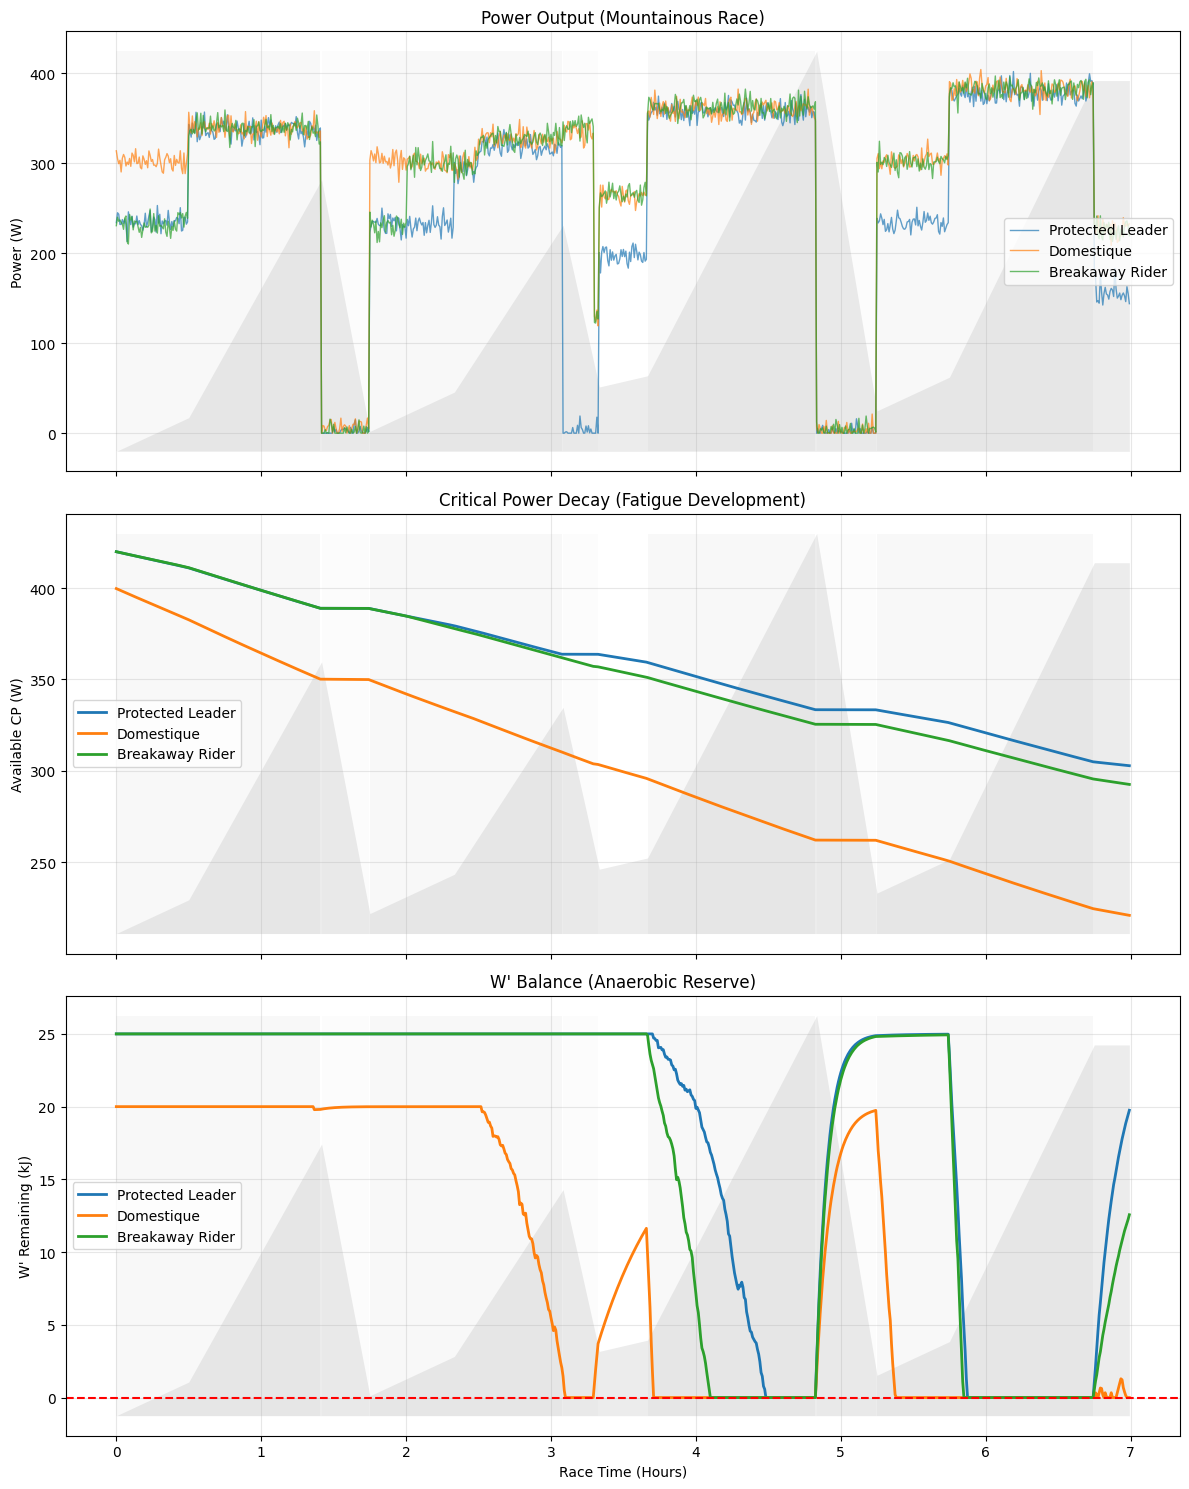

In [1]:

# --- Simulation Setup (Mountain RACE) ---

import numpy as np
import matplotlib.pyplot as plt


class Rider:
    def __init__(
        self,
        name,
        cp_fresh,
        w_prime,
        fatigue_resistance_lambda,
        recovery_tau0=300.0,      # base recovery timescale (s)
        tau_min=30.0,             # fastest possible recovery (s)
        tau_max=1800.0,           # slowest possible recovery (s)
        role="Leader"
    ):
        self.name = name
        self.cp_fresh = cp_fresh               # Critical Power (W)
        self.w_prime_cap = w_prime             # W' capacity (J)
        self.w_prime_bal = w_prime             # current W' (J)

        self.lambda_factor = fatigue_resistance_lambda  # sensitivity to accumulated work (per kJ)
        self.recovery_tau0 = recovery_tau0
        self.tau_min = tau_min
        self.tau_max = tau_max

        self.role = role

        self.cp_current = cp_fresh
        self.total_work_kj = 0.0

        # History
        self.history = {
            'time': [],
            'cp': [],
            'w_prime': [],
            'power': []
        }

    def update_fatigue(self, power_output, dt, rain_factor=1.0):
        """
        Updates:
        1) accumulated work
        2) CP decay (exponential with accumulated work)
        3) W' dynamics:
           - depletion above CP
           - exponential reconstitution below CP with tau depending on how easy it is
        """

        # --- Accumulate work (kJ) ---
        step_work_kj = (power_output * dt) / 1000.0
        self.total_work_kj += step_work_kj

        # --- 1) Exponential CP decay (durability) ---
        # CP(t) = CP0 * exp(-lambda * Work * rain_factor), floored at 50% CP0
        decay_exponent = -self.lambda_factor * self.total_work_kj * rain_factor
        cp_unfloored = self.cp_fresh * np.exp(decay_exponent)
        self.cp_current = max(0.5 * self.cp_fresh, cp_unfloored)

        # --- 2) W' dynamics ---
        if power_output > self.cp_current:
            # Depletion: W'(t+dt)=W'(t)-(P-CP)*dt
            drain = (power_output - self.cp_current) * dt
            self.w_prime_bal -= drain

        else:
            # Exponential reconstitution toward W'_max:
            # W'(t+dt) = W'_max - (W'_max - W'(t)) * exp(-dt/tau)
            # Choose tau smaller (faster recovery) when P is far below CP.
            dcp = self.cp_current - power_output  # how "easy" it is
            eps = 1e-6

            # tau scales like CP/dcp (large deficit => small tau => fast recovery)
            tau = self.recovery_tau0 * (self.cp_current / max(dcp, eps))
            tau = float(np.clip(tau, self.tau_min, self.tau_max))

            self.w_prime_bal = self.w_prime_cap - (self.w_prime_cap - self.w_prime_bal) * np.exp(-dt / tau)

        # Clamp W'
        self.w_prime_bal = max(0.0, min(self.w_prime_bal, self.w_prime_cap))

        # Store history
        self.history['cp'].append(self.cp_current)
        self.history['w_prime'].append(self.w_prime_bal)
        self.history['power'].append(power_output)


def calculate_power_required(speed_mps, slope_pct, is_drafting, wind_mps, rider_mass=70, bike_mass=7):
    # Constants
    g = 9.81
    rho = 1.225 # Air density
    crr = 0.004 # Rolling resistance
    
    # Drag Area (CdA)
    cda = 0.32
    if is_drafting:
    # Drafting benefit decreases sharply on steep climbs / low speed
        if slope_pct >= 5:
            cda = 0.32 * 0.90   # only ~10% benefit uphill
        else:
            cda = 0.32 * 0.65   # ~35% benefit on flats/fast sections

        
    total_mass = rider_mass + bike_mass
    
    # Forces
    # 1. Gravity: F_g = m * g * sin(arctan(slope)) ~ m * g * slope
    f_gravity = total_mass * g * (slope_pct / 100.0)
    
    # 2. Rolling Resistance: F_r = m * g * Crr
    f_rolling = total_mass * g * crr
    
    # 3. Air Resistance: F_a = 0.5 * rho * CdA * (v_air)^2
    # Wind vector: Headwind is positive in this simple 1D model
    v_air = speed_mps + wind_mps
    f_air = 0.5 * rho * cda * (v_air**2) * np.sign(v_air)
    
    total_force = f_gravity + f_rolling + f_air
    power = total_force * speed_mps
    
    return max(0, power) # No negative power (coasting = 0)


# Time settings
# ------------------------------------------------------------
# Race Profile (MOUNTAINOUS: La Marmotte style, synthetic)
# ------------------------------------------------------------
duration_hours = 7
dt = 30  # 30s resolution
time_steps = int(duration_hours * 3600 / dt)
time_axis = np.arange(0, duration_hours * 3600, dt) / 3600  # hours

# Helper: build piecewise segments
def add_segment(arr, start_idx, minutes, value):
    n = int((minutes * 60) / dt)
    end = min(len(arr), start_idx + n)
    arr[start_idx:end] = value
    return end

# Initialize profiles
slope_profile = np.zeros(time_steps)
wind_profile = np.zeros(time_steps)
rain_profile = np.ones(time_steps)

# Build a course with 4 long climbs + descents + valleys
idx = 0

# Warm-up valley
idx = add_segment(slope_profile, idx, minutes=30, value=1.0)

# Climb 1 (e.g., Glandon-ish)
idx = add_segment(slope_profile, idx, minutes=55, value=7.0)
idx = add_segment(slope_profile, idx, minutes=20, value=-7.0)  # descent

# Valley / transition
idx = add_segment(slope_profile, idx, minutes=35, value=1.0)

# Climb 2 (Télégraphe-ish)
idx = add_segment(slope_profile, idx, minutes=45, value=6.0)
idx = add_segment(slope_profile, idx, minutes=15, value=-6.0)

# Short valley
idx = add_segment(slope_profile, idx, minutes=20, value=0.5)

# Climb 3 (Galibier-ish)
idx = add_segment(slope_profile, idx, minutes=70, value=7.5)
idx = add_segment(slope_profile, idx, minutes=25, value=-8.0)

# Valley before final climb
idx = add_segment(slope_profile, idx, minutes=30, value=1.0)

# Climb 4 (Alpe d'Huez-ish)
idx = add_segment(slope_profile, idx, minutes=60, value=8.0)

# If any remaining time, keep it flat-ish
if idx < time_steps:
    slope_profile[idx:] = 0.0

# Speed profile: simple heuristic based on slope
# (This avoids solving a full pacing/speed dynamics model.)
# Typical climbing speeds and descent speeds are bounded.
speed_profile = np.zeros(time_steps)
for t in range(time_steps):
    s = slope_profile[t]
    if s >= 6:
        speed_profile[t] = 5.5   # ~20 km/h on steep climbs
    elif s >= 3:
        speed_profile[t] = 7.0   # ~25 km/h
    elif s >= 0:
        speed_profile[t] = 10.0  # ~36 km/h valley
    else:
        speed_profile[t] = 16.0  # ~58 km/h descents (cap)

# Optional: add wind on exposed sections (e.g., on top of climbs)
# Positive = headwind, negative = tailwind
wind_profile[int(2.5*3600/dt):int(3.3*3600/dt)] = 2.0  # 2 m/s headwind mid-race
#wind_profile[int(5.2*3600/dt):int(6.0*3600/dt)] = 3.0  # stronger headwind late

# Optional: rain in last hour
#rain_profile[int(6.0*3600/dt):] = 1.10  # 10% stress multiplier

# Create Riders
# Rider 1: Team Leader (Protected, high CP, high fatigue resistance)
leader = Rider(
    "Protected Leader",
    cp_fresh=420,
    w_prime=25000,
    fatigue_resistance_lambda=0.00005,
    recovery_tau0=280,   # faster recovery
    role="Leader"
)

domestique = Rider(
    "Domestique",
    cp_fresh=400,
    w_prime=20000,
    fatigue_resistance_lambda=0.00008,
    recovery_tau0=340,   # slightly slower recovery
    role="Domestique"
)

attacker = Rider(
    "Breakaway Rider",
    cp_fresh=420,
    w_prime=25000,
    fatigue_resistance_lambda=0.00005,
    recovery_tau0=300,
    role="Attacker"
)


riders = [leader, domestique, attacker]

# --- Run Simulation ---
for t in range(time_steps):
    current_speed = speed_profile[t]
    current_slope = slope_profile[t]
    current_wind = wind_profile[t]
    current_rain = rain_profile[t]
    
    for r in riders:
        is_drafting = True # Default
        
        # LOGIC FOR FLAT RACE:
        if r.role == "Attacker":
            # Mostly sheltered until attacks on climbs
            if current_slope >= 6 or (t > int(2*3600/dt)):  # attacks start after 2h
                is_drafting = False
            else:
                is_drafting = True

            
        elif r.role == "Domestique":
            # Works hard on climbs early/mid to pace, recovers on descents
            if current_slope >= 3 or (t < int(7.0*3600/dt)): 
                is_drafting = False
            else:
                is_drafting = True

                
        elif r.role == "Leader":
            # Protected on flats/descents, less so on climbs
            if current_slope >= 6:
                is_drafting = True   # still in a group, but benefit is small due to our CdA rule
            else:
                is_drafting = True

            

        
        # Calculate Power
        p_req = calculate_power_required(current_speed, current_slope, is_drafting, current_wind)
        
        # Add random variation
        p_req += np.random.normal(0, 8) 
        p_req = max(0, p_req)
        
        # Update Rider
        r.update_fatigue(p_req, dt, rain_factor=current_rain)


def compute_distance_elevation(speed_profile, slope_profile, dt, start_elev=0.0):
    """
    speed_profile: m/s
    slope_profile: percent grade (e.g., 7 for 7%)
    dt: seconds
    Returns:
      dist_km: cumulative distance in km
      elev_m: cumulative elevation in meters
    """
    N = len(speed_profile)
    dist_m = np.zeros(N)
    elev_m = np.zeros(N)
    elev_m[0] = start_elev

    for t in range(1, N):
        dx = speed_profile[t-1] * dt
        dist_m[t] = dist_m[t-1] + dx
        elev_m[t] = elev_m[t-1] + (slope_profile[t-1] / 100.0) * dx

    return dist_m / 1000.0, elev_m

dist_km, elev_m = compute_distance_elevation(speed_profile, slope_profile, dt, start_elev=0.0)


# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

def add_relief_background(ax, x, elev, slope, alpha=0.15):
    """
    Adds elevation as grey relief in the background, plus optional uphill/downhill shading.
    x: time_axis (hours) or dist_km
    elev: elevation (m)
    slope: slope (%)
    """
    # Normalize elevation to [0,1] for background scaling
    e = (elev - np.min(elev)) / (np.max(elev) - np.min(elev) + 1e-9)

    y0, y1 = ax.get_ylim()
    relief_y = y0 + e * (y1 - y0)

    # Grey filled elevation profile
    ax.fill_between(x, y0, relief_y, color="grey", alpha=alpha, linewidth=0)

    # Optional: shade uphill vs downhill lightly
    uphill = slope > 0.5
    downhill = slope < -0.5
    ax.fill_between(x, y0, y1, where=uphill, color="grey", alpha=0.05, linewidth=0)
    ax.fill_between(x, y0, y1, where=downhill, color="grey", alpha=0.02, linewidth=0)


# 1. Power Output
for r in riders:
    axes[0].plot(time_axis, r.history['power'], label=r.name, alpha=0.7, linewidth=1)
axes[0].set_title("Power Output (Mountainous Race)")
axes[0].set_ylabel("Power (W)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
add_relief_background(axes[0], time_axis, elev_m, slope_profile)

# 2. Critical Power Decay
for r in riders:
    axes[1].plot(time_axis, r.history['cp'], label=r.name, linewidth=2)
axes[1].set_title("Critical Power Decay (Fatigue Development)")
axes[1].set_ylabel("Available CP (W)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
add_relief_background(axes[1], time_axis, elev_m, slope_profile)

# 3. W' Balance
for r in riders:
    axes[2].plot(time_axis, np.array(r.history['w_prime'])/1000, label=r.name, linewidth=2)
axes[2].set_title("W' Balance (Anaerobic Reserve)")
axes[2].set_ylabel("W' Remaining (kJ)")
axes[2].set_xlabel("Race Time (Hours)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='red', linestyle='--')
add_relief_background(axes[2], time_axis, elev_m, slope_profile)


plt.tight_layout()
plt.savefig('fatigue_model_mountain.png')
#print("Flat race simulation complete.")